# Get NBR
---

The USGS [Landsat Normalized Burn Ratio (NBR)](https://www.usgs.gov/landsat-missions/landsat-normalized-burn-ratio) "is used to identify burned areas and provide a measure of burn severity. It is calculated as a ratio between the NIR and SWIR values in traditional fashion." 

For Landsat **8-9**, this means fetching bands *5* and *7* and performing the following computation:

$$ NBR = \frac{\text{Band }5 - \text{Band }7}{\text{Band }5 + \text{Band }7}$$


<br>

The USGS [Landsat Normalized Burn Ratio 2 (NBR2)](https://www.usgs.gov/landsat-missions/landsat-normalized-burn-ratio-2) "modifies the Normalized Burn Ratio (NBR) to highlight water sensitivity in vegetation and may be useful in post-fire recovery studies."

For Landsat **8-9**, this means fetching bands *6* and *7* and performing the following computation:

$$ NBR2 = \frac{\text{Band }6 - \text{Band }7}{\text{Band }6 + \text{Band }7}$$

<br>

The following is ademonstration of how to use functions defined in `raster_utils.py` and `download_utils.py` alongside an [existing Machine-to-Machine (M2M) Python API](https://github.com/Fergui/m2m-api/tree/main) to locally install USGS Landsat raster files and process them into NBR. If you prefer the sequel, the only difference is to fetch band *6* instead of band *5*.

### Creating the M2M object
Read in a valid username and token from a local `.env` file, and use these credentials to create the `M2M` object. This `M2M` object will be needed to search and download raster files.

In [1]:
from api import M2M
from dotenv import load_dotenv
import os

load_dotenv('.env')
username = os.environ['username']
token = os.environ['token']
m2m = M2M(username=username, token=token)

## download_utils.py

In [2]:
from download_utils import get_geojson_boundary, get_band_datasets, download_band_datasets, organize_band_files

### Finding Relevant Raster Files
Specify filters and search for the band datasets. To get NBR, we want bands 5 and 7.

In [3]:
bands = ['B5', 'B7'] # change to ['B6', 'B7] if desiring NBR2

aoi_geojson_path = './geojson/sierra_nevada_boundary.geojson'
start_date = '20-08-01'
end_date = '20-08-31'
max_cloud_cover = 10
max_results = 10000

aoi_geojson_boundary = get_geojson_boundary(aoi_geojson_path)

filters = {
    "startDate": start_date,
    "endDate": end_date,
    'maxCC': max_cloud_cover,
    "maxResults": max_results,
    'geoJsonType': aoi_geojson_boundary['type'],
    'geoJsonCoords': aoi_geojson_boundary['coordinates']
}

band_files = get_band_datasets(m2m, bands, filters)

searching for scenes ... done
19 hits - 19 scenes returned

    filtering for most recent scenes in date range ... done
    13 scenes remaining

searching for products ... done
26 products found

    filtering duplicates ... done
    13 products remaining

selecting band files ...
    13 band files found for B5
    13 band files found for B7


### Downloading Raster Files
`download_band_datasets` downloads the band files specified by parameter `band_files` to a local directory which is called `./ingest` by defult. It returns `band_filenames` and `band_metadata`

---

`band_filenames` is a dictionary of the form:
```python
    {
        <Band 5>: [<Band 5 Raster 1>.TIF, <Band 5 Raster 2>.TIF>, ... ],
        <Band 7>: [<Band 7 Raster 1>.TIF, <Band 7 Raster 2>.TIF>, ... ],
        ...
    }
```

`band_metadata` is a dictionary of the form:
```python
    {
        <Band 5>: [<Band 5 Raster 1 Metadata>, <Band 5 Raster 2 Metadata>, ... ],
        <Band 7>: [<Band 7 Raster 1 Metadata>, <Band 7 Raster 2 Metadata>, ... ],
        ...
    }
```

In [4]:
band_filenames, band_metadata = download_band_datasets(m2m, band_files)

downloading band files ...
    downloading B5 files ...
    downloading B7 files ...

succesfully saved data to directory ./ingest


###  Organizing Files After Downloading
The M2M API downloads raw band files to a directory `./ingest`, and adds the `.tar` suffix to every band file. 
`organize_band_files` will create new directories to hold raster data, sort files into different directories based their band, and delete the `./ingest` directory

---

Before `organize_band_files`:
```python
    ingest                           
    │   <Band 5 Raster 1>.TIF.tar      
    │   <Band 5 Raster 1>.TIF.tar.size 
    │   <Band 7 Raster 1>.TIF.tar      
    │   <Band 7 Raster 1>.TIF.tar.size 
    │   <Band 5 Raster 2>.TIF.tar      
    │   <Band 5 Raster 2>.TIF.tar.size 
    │   <Band 7 Raster 2>.TIF.tar      
    │   <Band 7 Raster 2>.TIF.tar.size 
    |   ...                          
```

<br>

After `organize_band_files`:
```python
    <Data Directory>
    │
    └───Band 5
    │   │   <Band 5 Raster 1>.TIF
    │   │   <Band 5 Raster 2>.TIF
    │   │   ...
    │   
    └───Band 7
    │   │   <Band 7 Raster 1>.TIF
    │   │   <Band 7 Raster 2>.TIF
    │   │   ...
    │
    │   ...
```

In [5]:
acq_directory = './ingest' # M2M API creates a folder called `ingest`
data_directory = './raster_data'
organize_band_files(acq_directory, data_directory, band_filenames)

successfully created directory ./raster_data

successfully created directory ./raster_data/B5
successfully moved B5 data to directory "./raster_data/B5"

successfully created directory ./raster_data/B7
successfully moved B7 data to directory "./raster_data/B7"

successfully removed ./ingest


## raster_utils.py

In [6]:
from raster_utils import create_nbr_rasters, reproject_directory, tile_directory, clip_raster, plot_raster

### Processing Bands to NBR
`create_nbr_rasters` will process the raw band 5 and 7 data into NBR. It will create a new directory `<Data Directory>/NBR`, and write the NBR data as new raster files in that directory.

---

Before `create_nbr_rasters`:

```python
    <Data Directory>
    │
    └───Band 5
    │   │   <Band 5 Raster 1>.tif
    │   │   <Band 5 Raster 2>.tif
    │   │   ...
    │   
    └───Band 7
    │   │   <Band 7 Raster 1>.TIF
    │   │   <Band 7 Raster 2>.TIF
    │   │   ...
    │
    │   ...
```

<br>

After `create_nbr_rasters`:

```python
    <Data Directory>
    │
    └───Band 5
    │   │   ...
    │   
    └───Band 7
    │   │   ...
    │ 
    └───NBR
    │   │   <NBR Raster File 1>.TIF
    │   │   <NBR Raster File 2>.TIF
    │   │   ...
```

In [7]:
nbr_directory = create_nbr_rasters(data_directory, band_filenames)

successfully created directory ./raster_data/NBR

computing NBR...


100%|██████████| 13/13 [00:21<00:00,  1.63s/it]


NBR files successfully written to ./raster_data/NBR


###   Reprojecting Rasters
`reproject_directory` reprojects all raster files in a directory to a desired CRS and saves the reprojected rasters to a new directory.

---

Before `reproject_directory`:

```python
    <Parent Directory>
    │
    └───<Directory>
    │   │   <Raster 1>.TIF
    │   │   <Raster 2>.TIF
    │   │   ...
    │   ...
```

<br>

After `reproject_directory`:

```python
    <Parent Directory>
    │
    └───<Directory>
    │   │   ...
    │ 
    └───Reprojected_<Directory>
    │   │   <Raster 1>.TIF
    │   │   <Raster 2>.TIF
    │   │   ...
    │   ...
```

In [8]:
reprojection_directory = reproject_directory(nbr_directory, crs='EPSG:4326')

successfully created directory ./raster_data/reprojected_NBR

reprojecting files in ./raster_data/NBR ...


100%|██████████| 13/13 [00:17<00:00,  1.31s/it]


succesfully projected all raster files in ./raster_data/NBR to EPSG:4326
reprojected files have been saved to ./raster_data/reprojected_NBR


### Tiling Rasters
`tile_directory` combines all raster files in a given directory into a single tiled raster.

tiling rasters in directory ./raster_data/reprojected_NBR ...
successfully saved tiled raster to file ./raster_data/tiled_reprojected_NBR


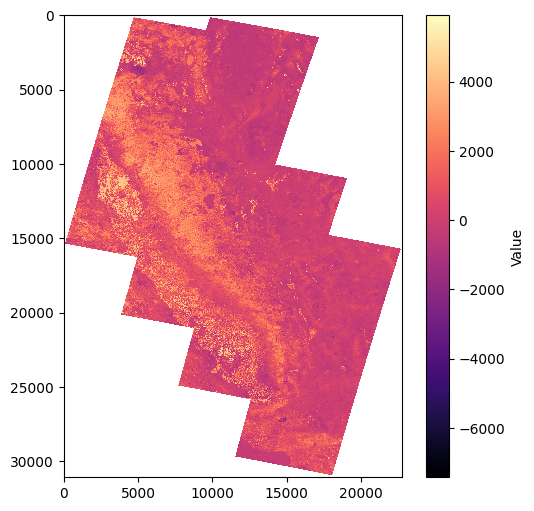

In [9]:
tiled_raster_filepath = tile_directory(reprojection_directory)
plot_raster(tiled_raster_filepath)

### Clipping Rasters
`clip_raster` clips a given raster file using the geojson in the provided path.

clipping raster in file ./raster_data/tiled_reprojected_NBR
successfully saved clipped raster to file ./raster_data/clipped_tiled_reprojected_NBR


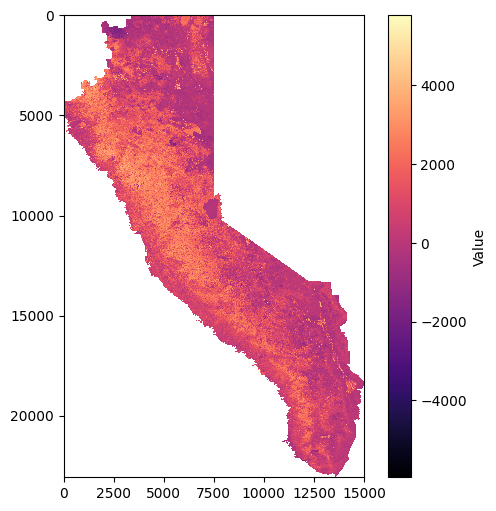

In [10]:
clipped_raster_filepath = clip_raster(tiled_raster_filepath, aoi_geojson_path=aoi_geojson_path)
plot_raster(clipped_raster_filepath)